In [1]:
import numpy as np
import torch
from torch import nn
from torch.distributions.normal import Normal
from sklearn import datasets
from dataclasses import dataclass
import matplotlib.pyplot as plt

 Source: https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

## Data

In [2]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

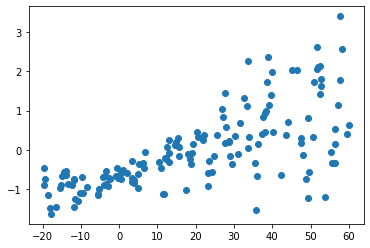

In [5]:
plt.scatter(x, y)

## MLE

In [7]:
# Go to pytorch world
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

In [12]:
m.eval()
mle_pred=[m(x_).detach().numpy() for x_ in X]

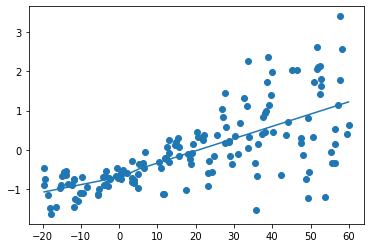

In [14]:
plt.scatter(x, y)
plt.plot(x, mle_pred)

## VI

In [15]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [16]:
def ll_gaussian(y, mu, log_var):
    """log-likelihood for gaussian"""
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [17]:
def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [18]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

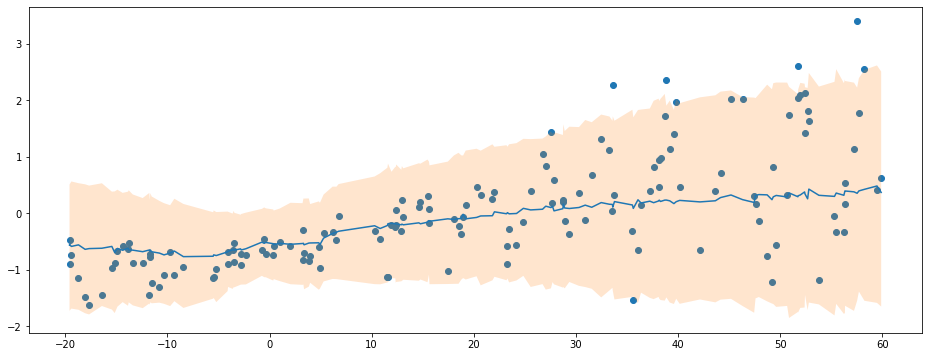

In [19]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

## Linear variational

In [27]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, in_features, out_features, parent, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        self.n_batches = n_batches
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.001
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        log_prior = Normal(0, prior_sd).log_prob(z) 
        log_p_q = Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).sum() / self.n_batches

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.parent.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.parent.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z
            

In [28]:
@dataclass
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)

In [30]:
epochs = 2000

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -Normal(y_pred, .1).log_prob(y).sum()
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl

m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

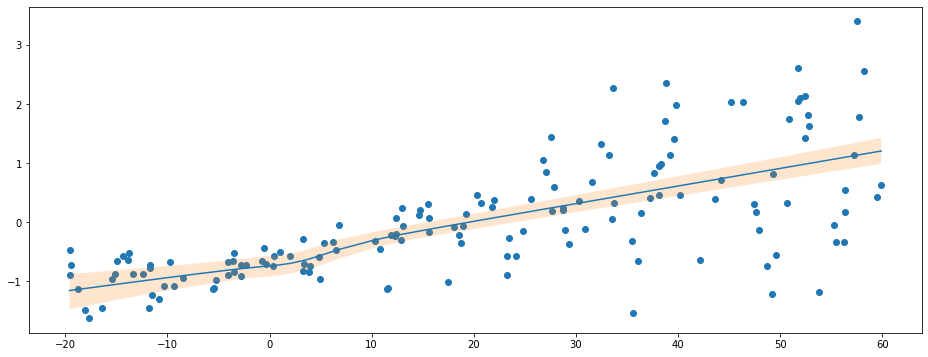

In [32]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)